In [25]:
import pandas as pd
from math import cos, radians, sqrt
from sklearn.neighbors import BallTree
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon, Point
import numpy as np
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import warnings
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
import statsmodels.formula.api as smf
from scipy.stats import skew, kurtosis
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu
from matplotlib.ticker import PercentFormatter

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:,.2f}'.format)
np.set_printoptions(suppress = True)
np.set_printoptions(precision = 2)

In [3]:
raw = "C:\\Users\\taavi\\Desktop\\BPHIL\\Raw data\\"
clean = "C:\\Users\\taavi\\Desktop\\BPHIL\\Clean data\\"

In [4]:
parcels = pd.read_csv(clean + 'blight.csv')
#parcels = pd.read_csv(clean + 'blight_and_values.csv')

In [4]:
demos = pd.read_csv(clean + 'clean_demos.csv')

In [6]:
values = pd.read_csv(clean + 'clean_values.csv')

### Getting 'demos_decayed'

In [13]:
years = range(values['year'].min(), values['year'].max() + 1)

In [ ]:
full = pd.DataFrame()

earthRadius = 6_378_137 # meters

distances = np.arange(50, 800, 50)
distances_radians = distances / earthRadius
weights = [(i + 1) / len(distances) for i, r in enumerate(distances)][::-1]

for year in tqdm(years):
    parcels_sub = parcels.loc[parcels['year'] == year].reset_index(drop = True)
    demos_sub = demos.loc[pd.to_datetime(demos['date'], format = 'mixed').dt.year == year].reset_index(drop = True)

    parcels_coords = np.radians(parcels_sub[['lat', 'lng']].to_numpy())
    demos_coords = np.radians(demos_sub[['lat', 'lng']].to_numpy())

    demo_tree = BallTree(demos_coords, metric = 'haversine')
    
    # count and sum values in each distance bin
    for d_m, d_r in zip(distances, distances_radians):
        indices_within_radius = demo_tree.query_radius(parcels_coords, r = d_r)
        counts = [len(idxs) for idxs in indices_within_radius]
        parcels_sub[f'demos_count_{d_m}'] = counts

    for i, r in enumerate(distances[::-1]):
        if r != distances[0]:
            parcels_sub[f'demos_count_{r}'] -= parcels_sub[f'demos_count_{distances[::-1][i + 1]}']

    parcels_sub['demos_decayed'] = (parcels_sub.iloc[:, -len(distances):] * weights).sum(axis = 1)

        
    full = pd.concat([full, parcels_sub], axis = 0)

full = full.reset_index(drop = True)

In [ ]:
full['demos_decayed'].value_counts(normalize = True)

In [ ]:
full.groupby('year')['demos_decayed'].mean()

In [ ]:
full.groupby(['year', 'blight'])['demos_decayed'].mean()[28:]

### Dataset of demos with values, then assigning blight cluster with a merge on parcelID

In [31]:
demos = demos[['parcelID', 'date', 'lat', 'lng', 'value', 'comm_res']]
demos['year'] = pd.to_datetime(demos['date'], format = 'mixed').dt.year
demos = demos.sort_values(by = ['year', 'parcelID']).reset_index(drop = True)

#### Extending demos temporally

In [32]:
years = pd.date_range(start = values['date'].min(), end = '2025-12-31', freq = 'Y')

In [ ]:
demos = demos.merge(pd.DataFrame({'date': years}), how = 'cross').sort_values(by = 'date').reset_index(drop = True)
demos['date'] = demos['date'].dt.year
demos = demos.rename(columns = {'date': 'year'}).sort_values(by = ['parcelID', 'year']).reset_index(drop = True)

In [73]:
full = pd.DataFrame()

earthRadius = 6_378_137 # meters

distances = np.arange(50, 800, 50)
distances_radians = distances / earthRadius
weights = [(i + 1) / len(distances) for i, r in enumerate(distances)][::-1]

for year in tqdm(years):
    demos_sub = demos.loc[demos['year'] == year.year].reset_index(drop = True)
    values_sub = values.loc[values['year'] == year.year].reset_index(drop = True)

    parcels_coords = np.radians(demos_sub[['lat', 'lng']].to_numpy())
    values_coords = np.radians(values_sub[['lat', 'lng']].to_numpy())

    value_tree = BallTree(values_coords, metric = 'haversine')
    
    # count and sum values in each distance bin
    for d_m, d_r in zip(distances, distances_radians):
        indices_within_radius = value_tree.query_radius(parcels_coords, r = d_r)
        counts = [len(idxs) for idxs in indices_within_radius]
        demos_sub[f'values_count_{d_m}'] = counts

        sums = [values_sub.loc[idxs, 'value'].sum() for idxs in indices_within_radius]
        demos_sub[f'values_sum_{d_m}'] = sums

    demos_sub = demos_sub.fillna(0)

    for i, r in enumerate(distances[::-1]):
        if r != distances[0]:
            demos_sub[f'values_count_{r}'] -= demos_sub[f'values_count_{distances[::-1][i + 1]}']
            demos_sub[f'values_sum_{r}'] -= demos_sub[f'values_sum_{distances[::-1][i + 1]}']
    
    demos_sub['values_count_decayed'] = (demos_sub.iloc[:, -len(distances) * 2::2] * weights).sum(axis = 1)
    demos_sub['values_sum_decayed'] = (demos_sub.iloc[:, -len(distances) * 2::2] * weights).sum(axis = 1)

    demos_sub['values_decayed'] = demos_sub['values_sum_decayed'] / demos_sub['values_count_decayed']

    full = pd.concat([full, demos_sub], axis = 0)

full = full.reset_index(drop = True)

100%|██████████| 10/10 [00:34<00:00,  3.42s/it]


In [74]:
demos = full.copy()

### Smoothing, deltas, and column cleanup

In [75]:
train = demos.loc[(demos['values_decayed'].isna() == False)]
x = train[['lat', 'lng']]
y = train['values_decayed']

knn = KNeighborsRegressor(n_neighbors = 5)
demos.loc[(demos['values_decayed'].isna()) | (demos['values_decayed'] == 0), 'values_decayed'] = knn.fit(x, y).predict(demos.loc[(demos['values_decayed'].isna()) | (demos['values_decayed'] == 0), ['lat', 'lng']])

demos = demos.sort_values(by = ['parcelID', 'year']).reset_index(drop = True)

same_parcel_prev_1 = demos['parcelID'].eq(demos['parcelID'].shift(1))
same_parcel_prev_2 = demos['parcelID'].eq(demos['parcelID'].shift(2))
same_parcel_prev_3 = demos['parcelID'].eq(demos['parcelID'].shift(3))
same_parcel_prev_4 = demos['parcelID'].eq(demos['parcelID'].shift(4))
same_parcel_prev_5 = demos['parcelID'].eq(demos['parcelID'].shift(5))

demos = (
    demos
    .assign(
        past_1 = demos['values_decayed'].shift(1).where(same_parcel_prev_1),
        past_2 = demos['values_decayed'].shift(2).where(same_parcel_prev_2),
        past_3 = demos['values_decayed'].shift(3).where(same_parcel_prev_3),
        past_4 = demos['values_decayed'].shift(4).where(same_parcel_prev_4),
        past_5 = demos['values_decayed'].shift(5).where(same_parcel_prev_5),
    )
    .assign(
        values_smoothed = lambda x: pd.concat([x['values_decayed'], x['past_1'], x['past_2'], x['past_3'], x['past_4'], x['past_5']], axis = 1).mean(axis = 1)
    )
    .assign(
        nom_delta_1 = lambda x: x['values_smoothed'].diff(1).where(same_parcel_prev_1).shift(-1),
        nom_delta_2 = lambda x: x['values_smoothed'].diff(2).where(same_parcel_prev_2).shift(-2),
        nom_delta_3 = lambda x: x['values_smoothed'].diff(3).where(same_parcel_prev_3).shift(-3),
        nom_delta_4 = lambda x: x['values_smoothed'].diff(4).where(same_parcel_prev_4).shift(-4),
        nom_delta_5 = lambda x: x['values_smoothed'].diff(5).where(same_parcel_prev_5).shift(-5),
        pct_delta_1 = lambda x: x['values_smoothed'].pct_change(1).where(same_parcel_prev_1).shift(-1),
        pct_delta_2 = lambda x: x['values_smoothed'].pct_change(2).where(same_parcel_prev_2).shift(-2),
        pct_delta_3 = lambda x: x['values_smoothed'].pct_change(3).where(same_parcel_prev_3).shift(-3),
        pct_delta_4 = lambda x: x['values_smoothed'].pct_change(4).where(same_parcel_prev_4).shift(-4),
        pct_delta_5 = lambda x: x['values_smoothed'].pct_change(5).where(same_parcel_prev_5).shift(-5),
    )
    .assign(
        cagr_1 = lambda x: ((x['pct_delta_1'] + 1) ** (1/1)) - 1,
        cagr_2 = lambda x: ((x['pct_delta_2'] + 1) ** (1/2)) - 1,
        cagr_3 = lambda x: ((x['pct_delta_3'] + 1) ** (1/3)) - 1,
        cagr_4 = lambda x: ((x['pct_delta_4'] + 1) ** (1/4)) - 1,
        cagr_5 = lambda x: ((x['pct_delta_5'] + 1) ** (1/5)) - 1
    )
    .reset_index(drop = True)
    [['parcelID', 'lat', 'lng', 'demo_year', 'year', 'values_smoothed', 'nom_delta_1', 'nom_delta_2', 'nom_delta_3', 'nom_delta_4', 'nom_delta_5',
      'pct_delta_1', 'pct_delta_2', 'pct_delta_3', 'pct_delta_4', 'pct_delta_5', 'cagr_1', 'cagr_2', 'cagr_3', 'cagr_4', 'cagr_5']]
)

In [76]:
print('MEAN')
print(demos[['pct_delta_1', 'pct_delta_2', 'pct_delta_3', 'pct_delta_4', 'pct_delta_5']].mean())
print('STDEV')
print(demos[['pct_delta_1', 'pct_delta_2', 'pct_delta_3', 'pct_delta_4', 'pct_delta_5']].std())
print('\n')
print('MEDIAN')
print(demos[['pct_delta_1', 'pct_delta_2', 'pct_delta_3', 'pct_delta_4', 'pct_delta_5']].median())
print('IQR')
print(demos[['pct_delta_1', 'pct_delta_2', 'pct_delta_3', 'pct_delta_4', 'pct_delta_5']].quantile(0.75) -
      demos[['pct_delta_1', 'pct_delta_2', 'pct_delta_3', 'pct_delta_4', 'pct_delta_5']].quantile(0.25))

MEAN
pct_delta_1   0.13
pct_delta_2   0.23
pct_delta_3   0.40
pct_delta_4   0.53
pct_delta_5   0.68
dtype: float64
STDEV
pct_delta_1   0.40
pct_delta_2   0.49
pct_delta_3   1.01
pct_delta_4   0.99
pct_delta_5   1.16
dtype: float64


MEDIAN
pct_delta_1   0.05
pct_delta_2   0.12
pct_delta_3   0.20
pct_delta_4   0.30
pct_delta_5   0.41
dtype: float64
IQR
pct_delta_1   0.13
pct_delta_2   0.26
pct_delta_3   0.41
pct_delta_4   0.57
pct_delta_5   0.73
dtype: float64


### Merging blight from parcels

In [7]:
demos = demos.merge(right = parcels[['parcelID', 'nbrhd', 'blight', 'blight_sqrt']].drop_duplicates(subset = 'parcelID'), on = 'parcelID', how = 'inner')

In [78]:
demos.to_csv(clean + 'demos_values_blight.csv', index = False)

In [44]:
demos = pd.read_csv(clean + 'demos_values_blight.csv')

### Investigating the relationship between demos and values, given underlying levels of blight

In [79]:
demos_testing = demos.loc[demos['demo_year'] == demos['year']]

In [80]:
model = smf.ols(formula = 'values_smoothed ~ C(blight_sqrt)', data = demos_testing).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        values_smoothed   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     65.83
Date:                Sun, 14 Sep 2025   Prob (F-statistic):           1.70e-68
Time:                        09:52:16   Log-Likelihood:                -12855.
No. Observations:                 961   AIC:                         2.572e+04
Df Residuals:                     954   BIC:                         2.576e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             1.92e+05   2

In [4]:
parcels = pd.read_csv(clean + 'blight_and_values.csv')
parcels['blight_sqrt'] = parcels['blight_sqrt'].astype(str)
parcels = parcels.loc[parcels['year'] >= 2020]

In [7]:
parcels = pd.read_csv(clean + 'blight_and_values.csv')
parcels['blight_sqrt'] = parcels['blight_sqrt'].astype(str)
parcels['value_mean'] = parcels.groupby('parcelID')['values_smoothed'].transform('mean')
demos = demos.loc[demos['demo_year'] == demos['year']]
demos['blight_sqrt'] = demos['blight_sqrt'].astype(str)
parcels = parcels.drop_duplicates(subset = 'parcelID')
exposure = pd.read_csv(clean + 'parcels_demo_exposure.csv')

KeyError: 'demo_year'

In [ ]:
exposure = pd.read_csv(clean + 'parcels_demo_exposure.csv')

In [ ]:
# demo_ids = demos['parcelID'].unique()
high_exposure_ids = exposure.loc[exposure['high_exposure'] == 1]['parcelID'].unique()
# pop_control = parcels.loc[~parcels['parcelID'].isin(demo_ids)]
pop_control = parcels.loc[~parcels['parcelID'].isin(high_exposure_ids)]
high_exposure_subset = parcels.loc[parcels['parcelID'].isin(high_exposure_ids)]

In [ ]:
# demo_ids = demos['parcelID'].unique()
high_exposure_ids = exposure.loc[exposure['high_exposure'] == 1]['parcelID'].unique()
# pop_control = parcels.loc[~parcels['parcelID'].isin(demo_ids)]
pop_control = parcels.loc[~parcels['parcelID'].isin(high_exposure_ids)]
high_exposure_subset = parcels.loc[parcels['parcelID'].isin(high_exposure_ids)]

# Step 2: create a list to hold results
results = []

# Step 3: loop over each blight cluster
for c in sorted(parcels['blight_sqrt'].unique()):
    demo_vals = high_exposure_subset.loc[high_exposure_subset['blight_sqrt'] == c, 'values_smoothed']
    control_vals = pop_control.loc[pop_control['blight_sqrt'] == c, 'value_mean']
    
    n_demo = len(demo_vals)
    n_control = len(control_vals)
    
    if n_demo == 0 or n_control == 0:
        continue
    
    # Mann-Whitney U test
    stat, p_val = mannwhitneyu(demo_vals, control_vals, alternative='two-sided')
    
    # Median values
    median_demo = demo_vals.median()
    median_control = control_vals.median()
    
    # Median difference (demo - control)
    median_diff = median_demo - median_control
    
    # Optional: rank-biserial effect size
    effect_size = 1 - (2 * stat / (n_demo * n_control))
    
    results.append({
        'Blight': c,
        'n_demo': n_demo,
        'n_control': n_control,
        'Median_demo': median_demo,
        'Median_control': median_control,
        'Median_diff': median_diff,
        'U_stat': stat,
        'p_value': p_val,
        'Effect_size': effect_size
    })

# Step 4: convert to DataFrame
summary_table = pd.DataFrame(results)

# Step 5: display
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
summary_table[['Blight', 'n_demo', 'n_control', 'Median_demo', 'Median_control', 'p_value']]

,Blight,n_demo,n_control,Median_demo,Median_control,p_value
0,5,1583,30206,"27,587.23","108,446.56",0.00
1,6,3793,8358,"29,066.43","209,947.27",0.00


In [ ]:
demo_vals.shape

In [ ]:
sns.kdeplot(parcels['value_mean'])
plt.show()

In [ ]:
skew(parcels['value_mean'])

In [ ]:
sns.kdeplot(demos['values_smoothed'])
plt.show()

In [ ]:
skew(demos['values_smoothed'])

In [ ]:
parcels['value_mean'].std() ** 2, demos['values_smoothed'].std() ** 2

In [ ]:
for c in demos.sort_values(by = 'blight_sqrt')['blight_sqrt'].unique():
    sub = parcels.loc[parcels['blight_sqrt'] == c]
    n = sub.shape[0]
    print('Cluster:', c)
    print(round(sub['value_mean'].median(), 1))
    print('n:', n)
    print('\n')

In [ ]:
for c in demos.sort_values(by = 'blight_sqrt')['blight_sqrt'].unique():
    sub = demos.loc[demos['blight_sqrt'] == c]
    n = sub.shape[0]
    print('Cluster:', c)
    print(round(sub['values_smoothed'].median(), 1))
    print('n:', n)
    print('\n')

In [ ]:
for c in demos['blight_sqrt'].unique():
    sub = parcels.loc[parcels['blight_sqrt'] == c]
    n = sub.shape[0]
    print('Cluster:', c)
    print(sub[['pct_delta_1', 'pct_delta_2', 'pct_delta_3', 'pct_delta_4', 'pct_delta_5']].median())
    print('n:', n)
    print('\n')

In [ ]:
for c in demos['blight_sqrt'].unique():
    sample = demos.loc[demos['demo_year'] == demos['year']]
    sub = sample.loc[sample['blight_sqrt'] == c]
    n = sub.shape[0]
    print('Cluster:', c)
    print(sub[['pct_delta_1', 'pct_delta_2', 'pct_delta_3', 'pct_delta_4', 'pct_delta_5']].median())
    print('n:', n)
    print('\n')

In [ ]:
fig = px.scatter_mapbox(demos, lat = 'lat', lon = 'lng', color = 'Blight', color_discrete_map = color_discrete_map, zoom = 10,
                        category_orders = {'Blight': ['1', '2', '3', '4', '5', '6', '7', 'Demo']}, hover_data = ['Neighborhood'])
fig.update_layout(mapbox_style = 'carto-positron')
fig.show()

In [80]:
exposure.groupby('high_exposure')['blight_sqrt'].value_counts()

high_exposure  blight_sqrt
0              3              39123
               2              34215
               5              30206
               1              14755
               4              11044
               6               8358
               7                954
1              6               3793
               5               1583
Name: count, dtype: int64

In [16]:
demos['blight_sqrt'].value_counts(normalize = True)

blight_sqrt
4   0.2716
2   0.2376
5   0.2207
1   0.1024
6   0.0844
3   0.0767
7   0.0066
Name: proportion, dtype: float64

In [17]:
demos.groupby(['year', 'high_exposure'])['blight_sqrt'].value_counts(normalize = True).reset_index().loc[lambda x: x['high_exposure'] == 1]

,year,high_exposure,blight_sqrt,proportion
7,2020,1,6,0.3325
8,2020,1,5,0.2640
9,2020,1,4,0.2377
10,2020,1,2,0.0794
11,2020,1,3,0.0685
12,2020,1,1,0.0179
20,2021,1,5,0.4485
21,2021,1,6,0.3724
22,2021,1,4,0.1640
23,2021,1,3,0.0135


In [4]:
parcels = pd.read_csv(clean + 'blight_and_values.csv')
parcels = parcels.loc[parcels['year'] >= 2020]
demos = pd.read_csv(clean + 'blight_and_demos.csv')
parcels['blight_sqrt'] = parcels['blight_sqrt'].astype(str)
parcels['value_mean'] = parcels.groupby('parcelID')['values_smoothed'].transform('mean')
demos['blight_sqrt'] = demos['blight_sqrt'].astype(str)

In [5]:
parcels = parcels.merge(right = demos[['parcelID', 'year', 'high_exposure']], on = ['parcelID', 'year'], how = 'left')

In [9]:
pct_cols = [f'pct_delta_{i + 1}' for i in range(5)]

In [31]:
pop_control = parcels.loc[parcels['high_exposure'] == 0]
high_exposure_subset = parcels.loc[parcels['high_exposure'] == 1]

# Step 3: loop over pct_delta columns
all_results_pre = []

for col in pct_cols:
    results = []
    for c in sorted(parcels['blight_sqrt'].unique()):
        demo_vals = high_exposure_subset.loc[high_exposure_subset['blight_sqrt'] == c, col].dropna()
        control_vals = pop_control.loc[pop_control['blight_sqrt'] == c, col].dropna()
        
        n_demo = len(demo_vals)
        n_control = len(control_vals)
        
        if n_demo == 0 or n_control == 0:
            continue
        
        # Mann-Whitney U test
        stat, p_val = mannwhitneyu(demo_vals, control_vals, alternative='two-sided')
        
        # Median values
        median_demo = demo_vals.median()
        median_control = control_vals.median()
        
        # Median difference (demo - control)
        median_diff = median_demo - median_control
        
        # Rank-biserial effect size
        effect_size = 1 - (2 * stat / (n_demo * n_control))

        skew_demo = high_exposure_subset.loc[high_exposure_subset['blight_sqrt'] == c, col].dropna().skew()
        skew_control = pop_control.loc[pop_control['blight_sqrt'] == c, col].dropna().skew()

        kurt_demo = kurtosis(high_exposure_subset.loc[high_exposure_subset['blight_sqrt'] == c, col].dropna())
        kurt_control = kurtosis(pop_control.loc[pop_control['blight_sqrt'] == c, col].dropna())
        
        results.append({
            'Blight_Cluster': c,
            'Pct_Delta': col,
            'n_demo': n_demo,
            'n_control': n_control,
            'Median_demo': median_demo,
            'Median_control': median_control,
            'Median_diff': median_diff,
            'U_stat': stat,
            'p_value': p_val,
            'skew_demo': skew_demo,
            'skew_control': skew_control,
            'kurt_demo': kurt_demo,
            'kurt_control': kurt_control,
            #'Effect_size': effect_size
        })
    
    all_results_pre.extend(results)

# Step 4: convert to DataFrame
summary_table_pct = pd.DataFrame(all_results_pre)#.assign(demo_to_control = lambda x: x['Median_demo'] / x['Median_control'])

# Step 5: display nicely
pd.set_option('display.float_format', lambda x: f'{x:,.4f}')
summary_table_pct.sort_values(by = ['Blight_Cluster', 'Pct_Delta'])

,Blight_Cluster,Pct_Delta,n_demo,n_control,Median_demo,Median_control,Median_diff,U_stat,p_value,skew_demo,skew_control,kurt_demo,kurt_control
0,1,pct_delta_1,158,73617,0.0233,0.0486,-0.0252,"3,945,069.0000",0.0000,0.4942,46.2373,-0.6894,"3,101.2259"
7,1,pct_delta_2,158,58862,0.0456,0.1059,-0.0603,"2,890,270.0000",0.0000,-0.7186,32.4202,-0.2312,"1,640.2153"
13,1,pct_delta_3,158,44107,0.0802,0.1424,-0.0623,"2,437,651.0000",0.0000,-0.5705,25.2980,-0.4429,"1,010.8813"
19,1,pct_delta_4,158,29352,0.0829,0.2118,-0.1289,"1,289,283.0000",0.0000,-0.5563,21.0858,0.4614,690.8225
25,1,pct_delta_5,158,14597,0.0796,0.2686,-0.1890,"501,785.0000",0.0000,-0.3152,16.2696,-0.4965,393.3487
1,2,pct_delta_1,1392,169683,0.0325,0.0479,-0.0154,"114,933,538.0000",0.0845,-1.7394,8.2968,2.1366,115.1437
8,2,pct_delta_2,794,136066,0.0382,0.1050,-0.0669,"43,028,376.0000",0.0000,0.4516,10.0386,-1.5251,141.1571
14,2,pct_delta_3,735,101910,0.0669,0.1496,-0.0828,"30,232,763.0000",0.0000,0.3874,8.4797,-1.5552,98.6347
20,2,pct_delta_4,716,67714,0.1015,0.2226,-0.1211,"15,384,781.0000",0.0000,-2.6995,7.9325,13.2235,81.9672
26,2,pct_delta_5,700,33515,0.1363,0.2923,-0.1560,"7,278,967.0000",0.0000,0.3586,6.7647,-1.2696,56.4262


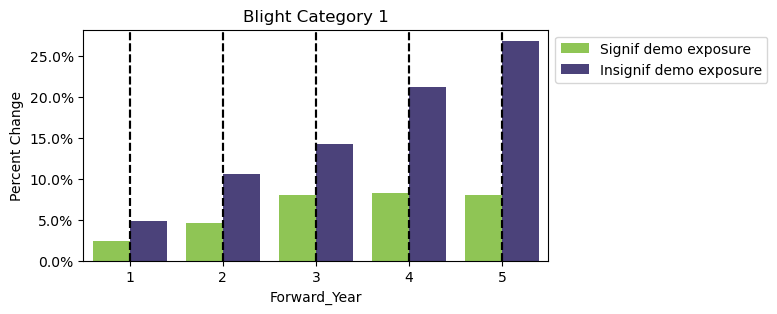

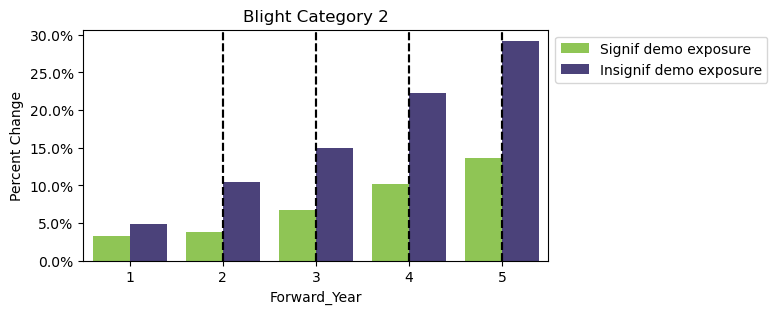

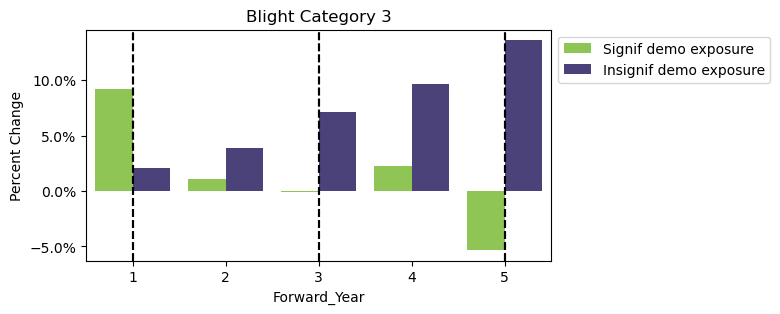

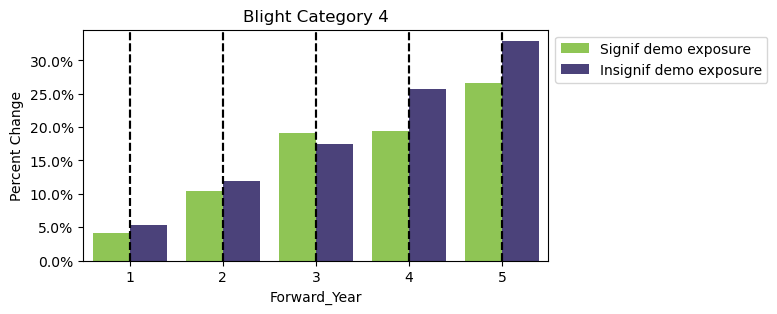

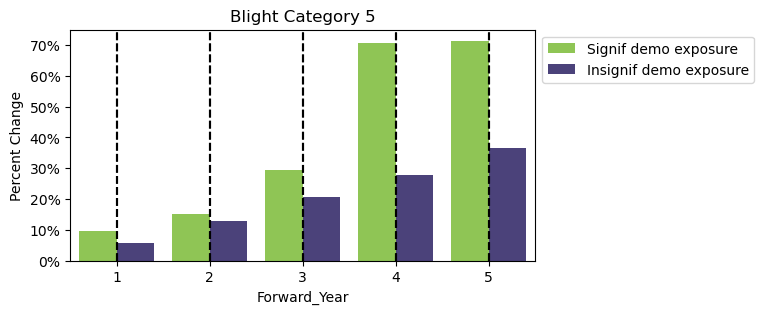

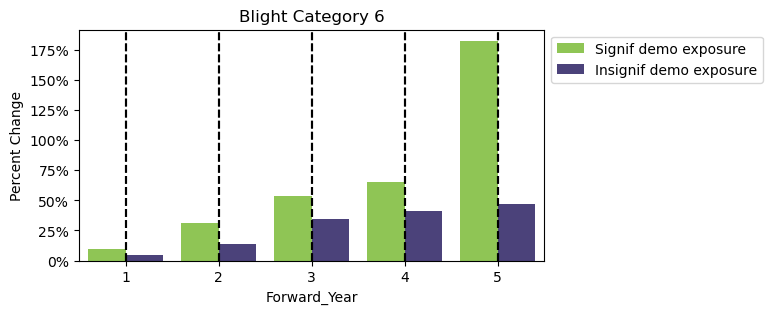

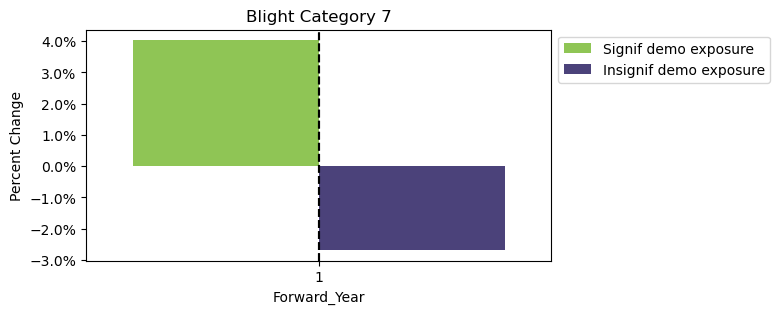

In [11]:
cmap = {
    'Signif demo exposure': '#90d743',
    'Insignif demo exposure': '#443983'
}

for i in ['1', '2', '3', '4', '5', '6', '7']:
    toPlot = (
        summary_table_pct
        .loc[summary_table_pct['Blight_Cluster'] == i]
        .assign(Forward_Year = lambda x: [str(i + 1) for i in range(x.shape[0])])
        .rename(columns = {'Median_demo': 'Signif demo exposure', 'Median_control': 'Insignif demo exposure'})
        [['Forward_Year', 'Signif demo exposure', 'Insignif demo exposure']]
        .melt(
            id_vars = 'Forward_Year'
        )
        .rename(columns = {'variable': 'Group', 'value': 'Percent Change'})
        .merge(
            right = summary_table_pct.loc[summary_table_pct['Blight_Cluster'] == i].assign(Forward_Year = lambda x: [str(i + 1) for i in range(x.shape[0])])[['Forward_Year', 'p_value']],
            on = 'Forward_Year', how = 'left'
        )
    )

    plt.figure(figsize = (6, 3))
    sns.barplot(toPlot, x = 'Forward_Year', y = 'Percent Change', hue = 'Group', palette = cmap)
    signifs = toPlot.loc[toPlot['p_value'] < 0.01]['Forward_Year'].values
    for s in signifs:
        plt.axvline(x = s, color = 'black', linestyle = '--')
    plt.title(f'Blight Category {i}')
    plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1))
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.show()

In [32]:
parcels

,parcelID,lat,lng,year,blight,blight_sqrt,viols_count_decayed,low_count_decayed,high_count_decayed,values_decayed,values_smoothed,viols_sqrt,low_sqrt,high_sqrt,nom_delta_1,nom_delta_2,nom_delta_3,nom_delta_4,nom_delta_5,pct_delta_1,pct_delta_2,pct_delta_3,pct_delta_4,pct_delta_5,cagr_1,cagr_2,cagr_3,cagr_4,cagr_5,nbrhd,value_mean,high_exposure
0,0001A00100000000,40.4423,-80.0105,2020,1,2,25.6667,62.3600,46.2105,"479,971.7531","392,351.8310",5.0662,7.8968,6.7978,"12,672.7213","-1,836.7465","22,292.6875","34,133.1990","6,246.2161",0.0323,-0.0047,0.0568,0.0870,0.0159,0.0323,-0.0023,0.0186,0.0211,0.0032,Central Business District,"404,603.1772",0
1,0001A00100000000,40.4423,-80.0105,2021,1,2,25.6667,62.3600,46.2105,"468,388.1590","405,024.5523",5.0662,7.8968,6.7978,"-14,509.4678","9,619.9662","21,460.4777","-6,426.5052",NaN,-0.0358,0.0238,0.0530,-0.0159,NaN,-0.0358,0.0118,0.0174,-0.0040,NaN,Central Business District,"404,603.1772",0
2,0001A00100000000,40.4423,-80.0105,2022,1,2,25.6667,62.3600,46.2105,"301,815.5708","390,515.0845",5.0662,7.8968,6.7978,"24,129.4340","35,969.9455","8,082.9626",NaN,NaN,0.0618,0.0921,0.0207,NaN,NaN,0.0618,0.0450,0.0069,NaN,NaN,Central Business District,"404,603.1772",0
3,0001A00100000000,40.4423,-80.0105,2023,1,2,25.6667,62.3600,46.2105,"473,329.7951","414,644.5185",5.0662,7.8968,6.7978,"11,840.5115","-16,046.4714",NaN,NaN,NaN,0.0286,-0.0387,NaN,NaN,NaN,0.0286,-0.0195,NaN,NaN,NaN,Central Business District,"404,603.1772",0
4,0001A00100000000,40.4423,-80.0105,2024,1,2,25.6667,62.3600,46.2105,"437,108.3118","426,485.0300",5.0662,7.8968,6.7978,"-27,886.9829",NaN,NaN,NaN,NaN,-0.0654,NaN,NaN,NaN,NaN,-0.0654,NaN,NaN,NaN,NaN,Central Business District,"404,603.1772",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864181,8120X00002000000,40.4311,-80.0684,2021,1,1,51.9333,4.9760,1.5733,"127,403.0070","93,186.5755",7.2065,2.2307,1.2543,"9,529.2206","17,540.8279","15,803.6195","27,110.8544",NaN,0.1023,0.1882,0.1696,0.2909,NaN,0.1023,0.0901,0.0536,0.0659,NaN,Oakwood,"103,710.1149",0
864182,8120X00002000000,40.4311,-80.0684,2022,1,1,51.9333,4.9760,1.5733,"117,586.8421","102,715.7961",7.2065,2.2307,1.2543,"8,011.6074","6,274.3989","17,581.6338",NaN,NaN,0.0780,0.0611,0.1712,NaN,NaN,0.0780,0.0301,0.0541,NaN,NaN,Oakwood,"103,710.1149",0
864183,8120X00002000000,40.4311,-80.0684,2023,1,1,51.9333,4.9760,1.5733,"144,537.7357","110,727.4035",7.2065,2.2307,1.2543,"-1,737.2084","9,570.0264",NaN,NaN,NaN,-0.0157,0.0864,NaN,NaN,NaN,-0.0157,0.0423,NaN,NaN,NaN,Oakwood,"103,710.1149",0
864184,8120X00002000000,40.4311,-80.0684,2024,1,1,51.9333,4.9760,1.5733,"66,022.5973","108,990.1950",7.2065,2.2307,1.2543,"11,307.2348",NaN,NaN,NaN,NaN,0.1037,NaN,NaN,NaN,NaN,0.1037,NaN,NaN,NaN,NaN,Oakwood,"103,710.1149",0


In [ ]:
parcels = (
    parcels
    .merge(right = demos[['parcelID', 'year', 'demos_count_decayed']], on = ['parcelID', 'year'], how = 'left')
    .assign(demos_sqrt = lambda x: np.sqrt(x['demos_count_decayed']))
)

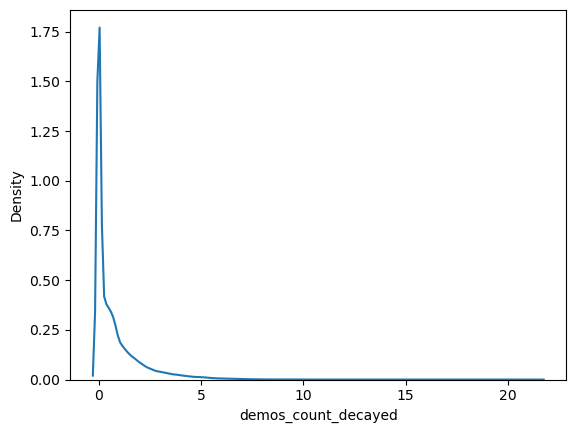

In [36]:
sns.kdeplot(parcels['demos_count_decayed'])
plt.show()

In [45]:
for i in parcels['nbrhd'].unique():
    parcels[i] = np.where(parcels['nbrhd'] == i, 1, 0)

In [79]:
model = smf.ols('pct_delta_1 ~ C(nbrhd)', data = parcels.loc[parcels['blight_sqrt'].isin(['5', '6'])]).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            pct_delta_1   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     1105.
Date:                Mon, 22 Sep 2025   Prob (F-statistic):               0.00
Time:                        09:15:40   Log-Likelihood:             1.1265e+05
No. Observations:              219700   AIC:                        -2.252e+05
Df Residuals:                  219647   BIC:                        -2.247e+05
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [78]:
model = smf.ols('pct_delta_1 ~ viols_sqrt + low_sqrt + high_sqrt + demos_sqrt + C(nbrhd)', data = parcels.loc[parcels['blight_sqrt'].isin(['5', '6'])]).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            pct_delta_1   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     1109.
Date:                Mon, 22 Sep 2025   Prob (F-statistic):               0.00
Time:                        09:15:37   Log-Likelihood:             1.1448e+05
No. Observations:              219700   AIC:                        -2.288e+05
Df Residuals:                  219643   BIC:                        -2.283e+05
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [37]:
parcels

,parcelID,lat,lng,year,blight,blight_sqrt,viols_count_decayed,low_count_decayed,high_count_decayed,values_decayed,values_smoothed,viols_sqrt,low_sqrt,high_sqrt,nom_delta_1,nom_delta_2,nom_delta_3,nom_delta_4,nom_delta_5,pct_delta_1,pct_delta_2,pct_delta_3,pct_delta_4,pct_delta_5,cagr_1,cagr_2,cagr_3,cagr_4,cagr_5,nbrhd,value_mean,high_exposure,demos_count_decayed
0,0001A00100000000,40.4423,-80.0105,2020,1,2,25.6667,62.3600,46.2105,"479,971.7531","392,351.8310",5.0662,7.8968,6.7978,"12,672.7213","-1,836.7465","22,292.6875","34,133.1990","6,246.2161",0.0323,-0.0047,0.0568,0.0870,0.0159,0.0323,-0.0023,0.0186,0.0211,0.0032,Central Business District,"404,603.1772",0,0.0000
1,0001A00100000000,40.4423,-80.0105,2021,1,2,25.6667,62.3600,46.2105,"468,388.1590","405,024.5523",5.0662,7.8968,6.7978,"-14,509.4678","9,619.9662","21,460.4777","-6,426.5052",NaN,-0.0358,0.0238,0.0530,-0.0159,NaN,-0.0358,0.0118,0.0174,-0.0040,NaN,Central Business District,"404,603.1772",0,0.0000
2,0001A00100000000,40.4423,-80.0105,2022,1,2,25.6667,62.3600,46.2105,"301,815.5708","390,515.0845",5.0662,7.8968,6.7978,"24,129.4340","35,969.9455","8,082.9626",NaN,NaN,0.0618,0.0921,0.0207,NaN,NaN,0.0618,0.0450,0.0069,NaN,NaN,Central Business District,"404,603.1772",0,0.0000
3,0001A00100000000,40.4423,-80.0105,2023,1,2,25.6667,62.3600,46.2105,"473,329.7951","414,644.5185",5.0662,7.8968,6.7978,"11,840.5115","-16,046.4714",NaN,NaN,NaN,0.0286,-0.0387,NaN,NaN,NaN,0.0286,-0.0195,NaN,NaN,NaN,Central Business District,"404,603.1772",0,0.0000
4,0001A00100000000,40.4423,-80.0105,2024,1,2,25.6667,62.3600,46.2105,"437,108.3118","426,485.0300",5.0662,7.8968,6.7978,"-27,886.9829",NaN,NaN,NaN,NaN,-0.0654,NaN,NaN,NaN,NaN,-0.0654,NaN,NaN,NaN,NaN,Central Business District,"404,603.1772",0,0.3333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864181,8120X00002000000,40.4311,-80.0684,2021,1,1,51.9333,4.9760,1.5733,"127,403.0070","93,186.5755",7.2065,2.2307,1.2543,"9,529.2206","17,540.8279","15,803.6195","27,110.8544",NaN,0.1023,0.1882,0.1696,0.2909,NaN,0.1023,0.0901,0.0536,0.0659,NaN,Oakwood,"103,710.1149",0,0.0000
864182,8120X00002000000,40.4311,-80.0684,2022,1,1,51.9333,4.9760,1.5733,"117,586.8421","102,715.7961",7.2065,2.2307,1.2543,"8,011.6074","6,274.3989","17,581.6338",NaN,NaN,0.0780,0.0611,0.1712,NaN,NaN,0.0780,0.0301,0.0541,NaN,NaN,Oakwood,"103,710.1149",0,0.4000
864183,8120X00002000000,40.4311,-80.0684,2023,1,1,51.9333,4.9760,1.5733,"144,537.7357","110,727.4035",7.2065,2.2307,1.2543,"-1,737.2084","9,570.0264",NaN,NaN,NaN,-0.0157,0.0864,NaN,NaN,NaN,-0.0157,0.0423,NaN,NaN,NaN,Oakwood,"103,710.1149",0,0.0000
864184,8120X00002000000,40.4311,-80.0684,2024,1,1,51.9333,4.9760,1.5733,"66,022.5973","108,990.1950",7.2065,2.2307,1.2543,"11,307.2348",NaN,NaN,NaN,NaN,0.1037,NaN,NaN,NaN,NaN,0.1037,NaN,NaN,NaN,NaN,Oakwood,"103,710.1149",0,0.0000
